# NLP Topic Modeling - Feature Demo

This notebook demonstrates all the features available in the `nlp-topic-modeling` package:

1. **Data Loading** - Loading the MOROCO dataset from Hugging Face
2. **Data Visualization** - Exploring the dataset with statistics and plots
3. **Preprocessing** - Romanian text normalization, tokenization, and filtering
4. **Topic Modeling** - TF-IDF + LDA hybrid pipeline for topic extraction
5. **Topic Analysis** - Interpreting and visualizing the discovered topics

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

---
## Data Loading

We use the MOROCO (Moldavian and Romanian Dialectal Corpus) dataset, which contains Romanian news articles across 6 categories.

In [2]:
from nlp_topic_modeling.data.loaders import load_MOROCO, get_category_name, MOROCO_CATEGORY_MAPPING

# Load the training split
df, columns = load_MOROCO(split='train')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {columns}")
print(f"\nCategory mapping:")
for cat_id, cat_name in MOROCO_CATEGORY_MAPPING.items():
    print(f"  {cat_id}: {cat_name}")

2026-01-14 00:35:57 - nlp_topic_modeling.data.loaders - INFO - Loading MOROCO dataset from Hugging Face
2026-01-14 00:35:59 - nlp_topic_modeling.data.loaders - INFO - Loaded 21719 documents with 6 categories
2026-01-14 00:35:59 - nlp_topic_modeling.data.loaders - INFO - Category distribution: {0: 1484, 1: 5522, 2: 5910, 3: 1890, 4: 3899, 5: 3014}
Dataset shape: (21719, 2)
Columns: ['category', 'sample']

Category mapping:
  0: culture
  1: finance
  2: politics
  3: science
  4: sports
  5: tech


In [3]:
# Add readable category names
df['category_name'] = df['category'].apply(get_category_name)

# Preview the data
df.head()

,category,sample,category_name
0,2,"“$NE$ cum am spus, nu este un sfârşit de drum ...",politics
1,2,Liberal - democratul $NE$ $NE$ renunţă la mand...,politics
2,3,Cel mai puternic computer din lume nu e în $NE...,science
3,4,Federaţia slovenă de fotbal ( $NE$ ) a anunţat...,sports
4,5,În cadrul unei întâlnirii a $NE$ de $NE$ din $...,tech


---
## Data Visualization

Let's explore the dataset with various visualizations.

### Category Distribution

In [4]:
# Calculate category statistics
category_stats = (
    df['category_name']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'category', 'category_name': 'count'})
)
category_stats.columns = ['category', 'count']
category_stats['percentage'] = (category_stats['count'] / category_stats['count'].sum() * 100).round(2)

print("Category Distribution:")
print(category_stats.to_string(index=False))

Category Distribution:
category  count  percentage
politics   5910       27.21
 finance   5522       25.42
  sports   3899       17.95
    tech   3014       13.88
 science   1890        8.70
 culture   1484        6.83


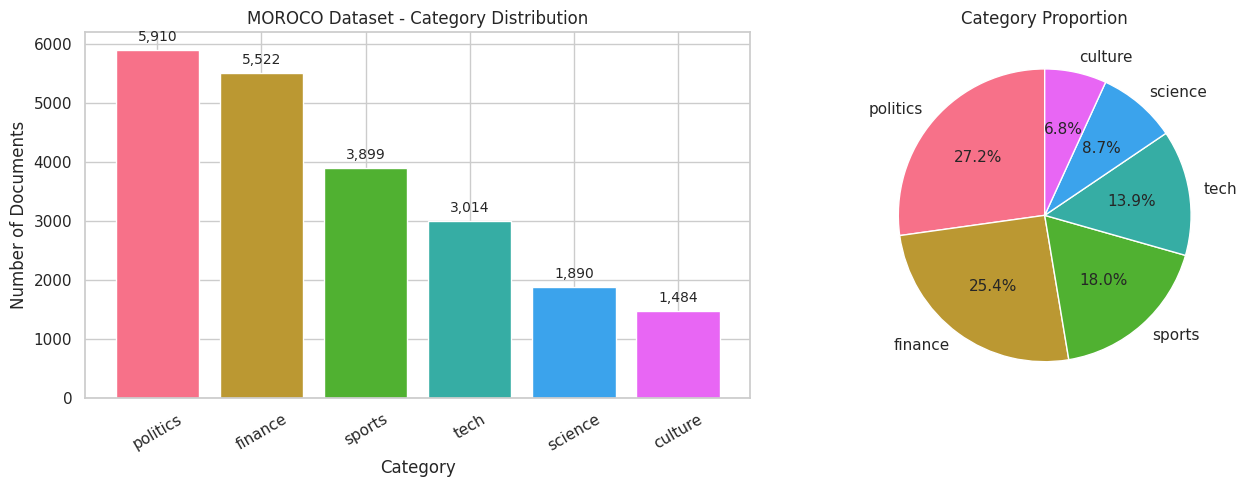

In [5]:
# Plot category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = sns.color_palette('husl', n_colors=6)
ax1 = axes[0]
bars = ax1.bar(category_stats['category'], category_stats['count'], color=colors)
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Documents')
ax1.set_title('MOROCO Dataset - Category Distribution')
ax1.tick_params(axis='x', rotation=30)

# Add count labels on bars
for bar, count in zip(bars, category_stats['count']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

# Pie chart
ax2 = axes[1]
ax2.pie(category_stats['count'], labels=category_stats['category'],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Category Proportion')

plt.tight_layout()
plt.show()

### Text Length Analysis

In [6]:
# Calculate text statistics
df['char_count'] = df['sample'].str.len()
df['word_count'] = df['sample'].str.split().str.len()

print("Text Length Statistics:")
print("\nCharacter Count:")
print(df['char_count'].describe().round(2))
print("\nWord Count:")
print(df['word_count'].describe().round(2))

Text Length Statistics:

Character Count:
count    21719.00
mean      1710.95
std       1786.67
min          5.00
25%        819.00
50%       1325.00
75%       2043.00
max      92966.00
Name: char_count, dtype: float64

Word Count:
count    21719.00
mean       308.73
std        322.77
min          2.00
25%        151.00
50%        238.00
75%        365.00
max      15988.00
Name: word_count, dtype: float64


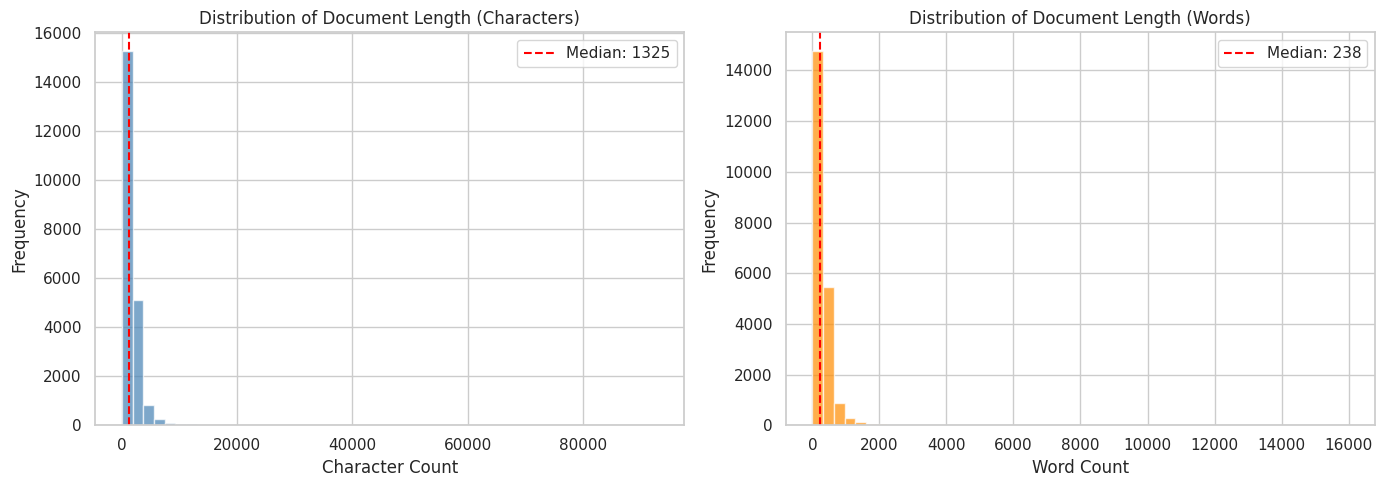

In [7]:
# Plot text length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count distribution
ax1 = axes[0]
ax1.hist(df['char_count'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(df['char_count'].median(), color='red', linestyle='--', label=f'Median: {df["char_count"].median():.0f}')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Document Length (Characters)')
ax1.legend()

# Word count distribution
ax2 = axes[1]
ax2.hist(df['word_count'], bins=50, color='darkorange', edgecolor='white', alpha=0.7)
ax2.axvline(df['word_count'].median(), color='red', linestyle='--', label=f'Median: {df["word_count"].median():.0f}')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Document Length (Words)')
ax2.legend()

plt.tight_layout()
plt.show()

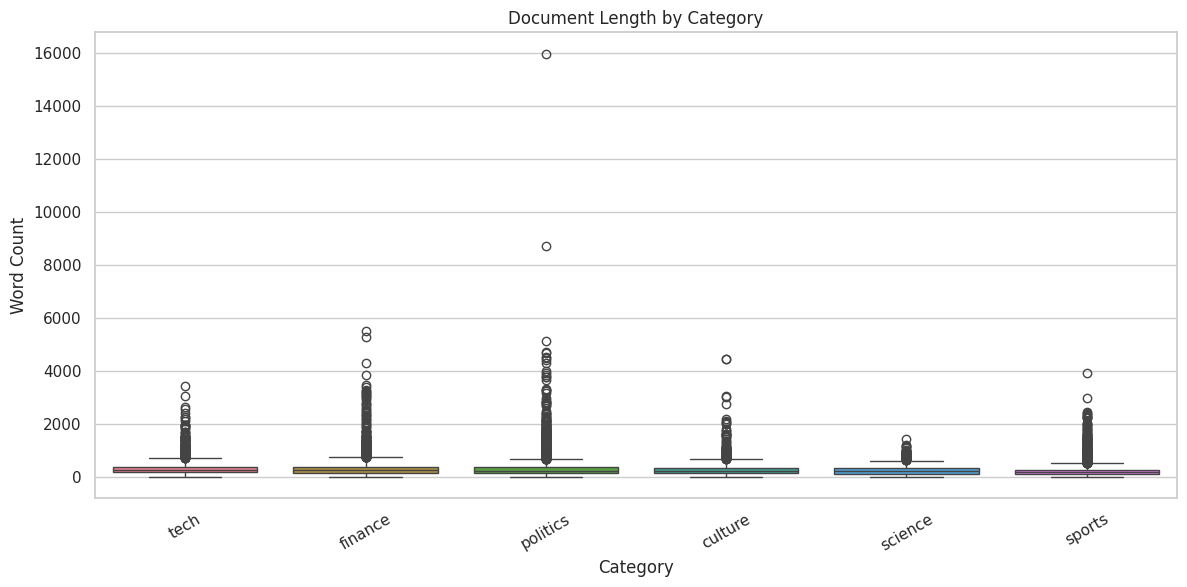

In [8]:
# Text length by category
fig, ax = plt.subplots(figsize=(12, 6))

category_order = df.groupby('category_name')['word_count'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='category_name', y='word_count', order=category_order, palette='husl', ax=ax)
ax.set_xlabel('Category')
ax.set_ylabel('Word Count')
ax.set_title('Document Length by Category')
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

### Sample Documents

In [9]:
# Display sample documents from each category
print("Sample Documents by Category:")
print("=" * 80)

for category_name in MOROCO_CATEGORY_MAPPING.values():
    sample = df[df['category_name'] == category_name].sample(1, random_state=42).iloc[0]
    print(f"\n[{category_name.upper()}]")
    print(f"{sample['sample'][:300]}...")
    print("-" * 80)

Sample Documents by Category:

[CULTURE]
Spectacol de excepţie pe scena $NE$ $NE$ . Doi artişti de renume care şi - au pus mereu talentul în slujba patriotismului, $NE$ $NE$ şi $NE$ $NE$ $NE$ s - au întâlnit pentru a aduce publicului cele mai frumoase cântece şi amintiri istorice din momente cruciale pentru ţara noastră . Spectacolul va fi...
--------------------------------------------------------------------------------

[FINANCE]
Primăriile au făcut un program pentru susţinerea familiei şi acordă o nouă alocaţie financiară pentru copii cu scopul de a - i sprijini . Familiile vizate sunt cele cu venituri reduse .   $NE$ continuarea pe www . spynews . ro...
--------------------------------------------------------------------------------

[POLITICS]
O persoană a murit şi alta a fost rănită grav, miercuri, la primele ore ale dimineţii, în urma unui accident rutier produs în zona românească a $NE$ de $NE$ a $NE$ ( $NE$ ) $NE$ $NE$ informează un comunicat de presă al $NE$ de $NE$ $NE$ $NE

---
## Text Preprocessing

The preprocessing module provides Romanian-specific text normalization, including:
- Diacritic normalization (ş → ș, ţ → ț)
- Dialect normalization (î → â mid-word)
- $NE$ token removal (MOROCO named entity placeholders)
- POS-filtered tokenization and lemmatization

In [10]:
from nlp_topic_modeling.preprocessing import (
    normalize_diacritics,
    normalize_dialect,
    remove_ne_tokens,
    RomanianTokenizer,
    get_all_stopwords,
    get_news_boilerplate_stopwords,
    TOPIC_POS_TAGS,
)

### Diacritic Normalization

In [11]:
# Demonstrate diacritic normalization
examples = [
    "Şcoala ţării noastre",
    "România şi Moldova",
    "Preţurile cresc",
]

print("Diacritic Normalization (cedilla → comma-below):")
print("=" * 60)
for text in examples:
    normalized = normalize_diacritics(text)
    print(f"  {text}")
    print(f"→ {normalized}")
    print()

Diacritic Normalization (cedilla → comma-below):
  Şcoala ţării noastre
→ Școala țării noastre

  România şi Moldova
→ România și Moldova

  Preţurile cresc
→ Prețurile cresc



### Dialect Normalization (RO-MD)

In [12]:
# Demonstrate dialect normalization (î → â mid-word)
examples = [
    "Eu sînt acasă cînd vîntul bate",
    "Pămîntul este rotund",
    "Rîul curge lîngă sat",
]

print("Dialect Normalization (Moldovan î → Romanian â):")
print("=" * 60)
for text in examples:
    normalized = normalize_dialect(text)
    print(f"  {text}")
    print(f"→ {normalized}")
    print()

Dialect Normalization (Moldovan î → Romanian â):
  Eu sînt acasă cînd vîntul bate
→ Eu sânt acasă când vântul bate

  Pămîntul este rotund
→ Pământul este rotund

  Rîul curge lîngă sat
→ Râul curge lângă sat



### Named Entity Token Removal

In [13]:
# Show $NE$ token removal
sample_with_ne = df[df['sample'].str.contains(r'\$NE\$')].iloc[0]['sample']

print("$NE$ Token Removal:")
print("=" * 60)
print("\nOriginal (first 300 chars):")
print(sample_with_ne[:300])
print("\nAfter removal:")
print(remove_ne_tokens(sample_with_ne)[:300])

$NE$ Token Removal:

Original (first 300 chars):
“$NE$ cum am spus, nu este un sfârşit de drum . Vom continua lupta cu toate instrumentele şi cu toate mijloacele legale, parlamentare şi civice pe care le avem la dispoziţie . Evident că vom contesta la $NE$ această lege, au anunţat şi colegii de la $NE$ o astfel de contestaţie . Practic trebuie uti

After removal:
“ cum am spus, nu este un sfârşit de drum . Vom continua lupta cu toate instrumentele şi cu toate mijloacele legale, parlamentare şi civice pe care le avem la dispoziţie . Evident că vom contesta la  această lege, au anunţat şi colegii de la  o astfel de contestaţie . Practic trebuie utilizat orice 


### POS-Filtered Tokenization

In [14]:
# Initialize tokenizer
tokenizer = RomanianTokenizer()

print(f"Topic POS Tags: {TOPIC_POS_TAGS}")
print("(Focus on 'topical skeleton' - nouns and adjectives, not verbs)")

2026-01-14 00:36:05 - nlp_topic_modeling.preprocessing.tokenizer - INFO - Loaded spaCy model: ro_core_news_sm
Topic POS Tags: {'ADJ', 'PROPN', 'NOUN'}
(Focus on 'topical skeleton' - nouns and adjectives, not verbs)


In [15]:
# Demonstrate POS-filtered tokenization
text = "Ministrul economiei a declarat că piața financiară românească crește rapid."

print("POS-Filtered Tokenization:")
print("=" * 60)
print(f"\nInput: {text}")

# All tokens with POS tags
all_tokens = tokenizer.get_tokens_with_pos(text)
print("\nAll tokens with POS tags:")
for token, pos in all_tokens:
    print(f"  {token:15} → {pos}")

# POS-filtered tokens (NOUN, PROPN, ADJ only)
filtered_tokens = tokenizer.tokenize_pos_filtered(text)
print(f"\nFiltered tokens (NOUN/PROPN/ADJ only): {filtered_tokens}")

POS-Filtered Tokenization:

Input: Ministrul economiei a declarat că piața financiară românească crește rapid.

All tokens with POS tags:
  Ministrul       → NOUN
  economiei       → NOUN
  a               → AUX
  declarat        → VERB
  că              → SCONJ
  piața           → NOUN
  financiară      → ADJ
  românească      → ADJ
  crește          → AUX
  rapid           → ADV
  .               → PUNCT

Filtered tokens (NOUN/PROPN/ADJ only): ['ministru', 'economie', 'piață', 'financiar', 'românesc']


###  Stopwords

In [16]:
# Show stopword counts
all_stopwords = get_all_stopwords(include_news_boilerplate=True)
news_stopwords = get_news_boilerplate_stopwords()

print("Stopword Statistics:")
print(f"  Total stopwords: {len(all_stopwords)}")
print(f"  News boilerplate stopwords: {len(news_stopwords)}")

print("\nSample news boilerplate stopwords (verbal noise + web artifacts):")
sample_news_sw = sorted(list(news_stopwords))[:20]
print(f"  {', '.join(sample_news_sw)}")

Stopword Statistics:
  Total stopwords: 539
  News boilerplate stopwords: 81

Sample news boilerplate stopwords (verbal noise + web artifacts):
  actualizare, actualizat, afirma, afirmat, afirmatie, afirmație, anunt, anunta, anuntat, anunț, anunța, anunțat, arata, aratat, articol, articole, arăta, arătat, breaking, cadru


---
## Topic Modeling (TF-IDF + LDA)

The LDA module implements a **Filter-then-Feed** architecture:
1. Use TF-IDF to select top-K informative features
2. Extract BoW counts for those features
3. Train LDA on the BoW counts

This maintains LDA's probabilistic integrity while benefiting from TF-IDF's noise reduction.

In [17]:
from nlp_topic_modeling.lda import (
    train_topic_model,
    TopicModelingPipeline,
    PipelineConfig,
    TFIDFConfig,
    LDAConfig,
)

In [18]:
# Use a sample for faster demo (use full dataset for production)
SAMPLE_SIZE = 2000
df_sample = df.sample(SAMPLE_SIZE, random_state=42)

print(f"Training on {len(df_sample)} documents (sampled for demo)")
print(f"Category distribution in sample:")
print(df_sample['category_name'].value_counts())

Training on 2000 documents (sampled for demo)
Category distribution in sample:
category_name
politics    552
finance     489
sports      354
tech        307
science     160
culture     138
Name: count, dtype: int64


### Train Topic Model

In [19]:
# Train the topic model
pipeline = train_topic_model(
    df_sample,
    n_topics=6,  # Match MOROCO categories
    text_column='sample',
    show_progress=True,
)

print(f"\nVocabulary size: {pipeline.get_vocabulary_size()}")

2026-01-14 00:36:05 - nlp_topic_modeling.lda.pipeline - INFO - Preparing 2000 documents for topic modeling


Preprocessing:   0%|          | 0/2000 [00:00<?, ?it/s]

2026-01-14 00:36:05 - nlp_topic_modeling.preprocessing.tokenizer - INFO - Loaded spaCy model: ro_core_news_sm


Preprocessing: 100%|██████████| 2000/2000 [00:47<00:00, 42.45it/s]

2026-01-14 00:36:52 - nlp_topic_modeling.lda.pipeline - INFO - Prepared 1997/2000 non-empty documents
2026-01-14 00:36:52 - nlp_topic_modeling.lda.pipeline - INFO - Fitting TF-IDF vectorizer
2026-01-14 00:36:52 - nlp_topic_modeling.lda.vectorizer - INFO - Fitting TF-IDF on 2000 documents


2026-01-14 00:36:53 - nlp_topic_modeling.lda.vectorizer - INFO - Selected vocabulary size: 4678
2026-01-14 00:36:53 - nlp_topic_modeling.lda.vectorizer - INFO - Transformed 2000 documents to (2000, 4678)
2026-01-14 00:36:53 - nlp_topic_modeling.lda.pipeline - INFO - Fitting LDA model
2026-01-14 00:36:53 - nlp_topic_modeling.lda.model - INFO - Fitting LDA with 6 topics on 2000 documents, 4678 features
2026-01-14 00:41:51 - nlp_topic_modeling.lda.model - INFO - LDA fitting complete. Perplexity: 1379.02

Vocabulary size: 4678


### View Discovered Topics

In [20]:
# Get topics with weights
topics = pipeline.get_topics(n_words=10)

print("Discovered Topics:")
print("=" * 80)
for i, topic in enumerate(topics):
    words = [f"{word} ({weight:.2f})" for word, weight in topic[:8]]
    print(f"\nTopic {i}: {', '.join(words)}")

Discovered Topics:

Topic 0: stat (783.28), țară (776.62), președinte (689.05), proiect (509.78), ministru (458.85), politic (445.82), public (424.94), parte (399.52)

Topic 1: companie (603.32), lună (482.41), leu (442.95), euro (393.89), piață (310.78), creștere (279.01), produs (271.55), preț (251.49)

Topic 2: meci (364.43), echipă (299.57), minut (210.37), scor (181.79), turneu (168.00), finală (160.36), jucător (137.96), victorie (131.84)

Topic 3: loc (240.38), lume (214.17), viață (203.47), într (189.34), utilizator (175.56), studiu (170.04), lucru (161.98), urmă (150.49)

Topic 4: oră (302.09), loc (299.11), eveniment (180.76), sportiv (161.77), metru (112.06), bun (110.14), antrenor (102.12), film (95.71)

Topic 5: ban (307.15), vot (305.55), leu (303.12), alegere (147.91), primar (146.75), loc (137.93), referendum (136.77), oraș (133.37)


In [21]:
# Simple topic word display
print("\nTopic Summary (top 8 words):")
print("=" * 60)
topic_words = pipeline.get_topic_words(n_words=8)
for i, words in enumerate(topic_words):
    print(f"Topic {i}: {', '.join(words)}")


Topic Summary (top 8 words):
Topic 0: stat, țară, președinte, proiect, ministru, politic, public, parte
Topic 1: companie, lună, leu, euro, piață, creștere, produs, preț
Topic 2: meci, echipă, minut, scor, turneu, finală, jucător, victorie
Topic 3: loc, lume, viață, într, utilizator, studiu, lucru, urmă
Topic 4: oră, loc, eveniment, sportiv, metru, bun, antrenor, film
Topic 5: ban, vot, leu, alegere, primar, loc, referendum, oraș


---
## Topic Analysis & Visualization

### Document-Topic Distribution

In [22]:
# Get document-topic distributions
doc_topics = pipeline.fit_transform(df_sample, show_progress=False)

print(f"Document-topic matrix shape: {doc_topics.shape}")
print(f"(n_documents, n_topics)")

2026-01-14 00:41:51 - nlp_topic_modeling.lda.pipeline - INFO - Preparing 2000 documents for topic modeling
2026-01-14 00:42:40 - nlp_topic_modeling.lda.pipeline - INFO - Prepared 1997/2000 non-empty documents
2026-01-14 00:42:40 - nlp_topic_modeling.lda.pipeline - INFO - Fitting TF-IDF vectorizer
2026-01-14 00:42:40 - nlp_topic_modeling.lda.vectorizer - INFO - Fitting TF-IDF on 2000 documents
2026-01-14 00:42:40 - nlp_topic_modeling.lda.vectorizer - INFO - Selected vocabulary size: 4678
2026-01-14 00:42:41 - nlp_topic_modeling.lda.vectorizer - INFO - Transformed 2000 documents to (2000, 4678)
2026-01-14 00:42:41 - nlp_topic_modeling.lda.pipeline - INFO - Fitting LDA model
2026-01-14 00:42:41 - nlp_topic_modeling.lda.model - INFO - Fitting LDA with 6 topics on 2000 documents, 4678 features
2026-01-14 00:47:22 - nlp_topic_modeling.lda.model - INFO - LDA fitting complete. Perplexity: 1379.02
2026-01-14 00:47:22 - nlp_topic_modeling.lda.vectorizer - INFO - Transformed 2000 documents to (20

In [23]:
# Get dominant topic for each document
dominant_topics = pipeline.get_dominant_topics(doc_topics)
df_sample = df_sample.copy()
df_sample['dominant_topic'] = dominant_topics

# Topic distribution
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
print("Documents per Topic:")
for topic_id, count in topic_counts.items():
    print(f"  Topic {topic_id}: {count} documents ({count/len(df_sample)*100:.1f}%)")

Documents per Topic:
  Topic 0: 796 documents (39.8%)
  Topic 1: 426 documents (21.3%)
  Topic 2: 134 documents (6.7%)
  Topic 3: 372 documents (18.6%)
  Topic 4: 174 documents (8.7%)
  Topic 5: 98 documents (4.9%)


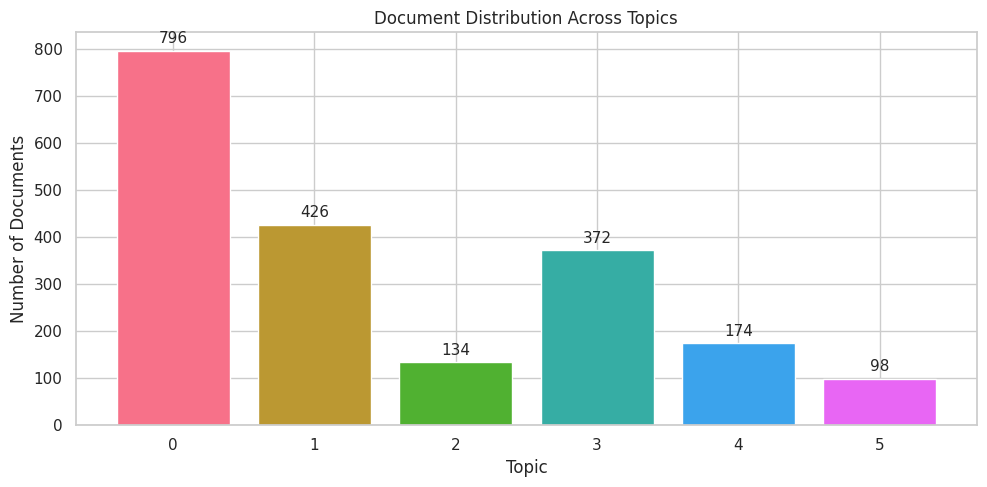

In [24]:
# Plot topic distribution
fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette('husl', n_colors=6)
bars = ax.bar(range(6), [topic_counts.get(i, 0) for i in range(6)], color=colors)

ax.set_xlabel('Topic')
ax.set_ylabel('Number of Documents')
ax.set_title('Document Distribution Across Topics')
ax.set_xticks(range(6))

# Add count labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 10,
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Topic-Category Correspondence

In [25]:
# Create topic-category confusion matrix
confusion = pd.crosstab(
    df_sample['category_name'],
    df_sample['dominant_topic'],
    normalize='index'
) * 100

# Reorder columns
confusion = confusion.reindex(columns=range(6), fill_value=0)

print("Topic-Category Correspondence (% of category in each topic):")
print(confusion.round(1))

Topic-Category Correspondence (% of category in each topic):
dominant_topic     0     1     2     3     4     5
category_name                                     
culture         17.4   5.1   0.0  28.3  46.4   2.9
finance         38.4  41.9   0.0   7.0   2.5  10.2
politics        87.1   1.3   0.4   3.6   0.9   6.7
science          5.0  46.9   0.6  44.4   1.9   1.2
sports           8.2   3.4  37.0  28.5  22.6   0.3
tech            21.5  39.1   0.0  34.9   3.3   1.3


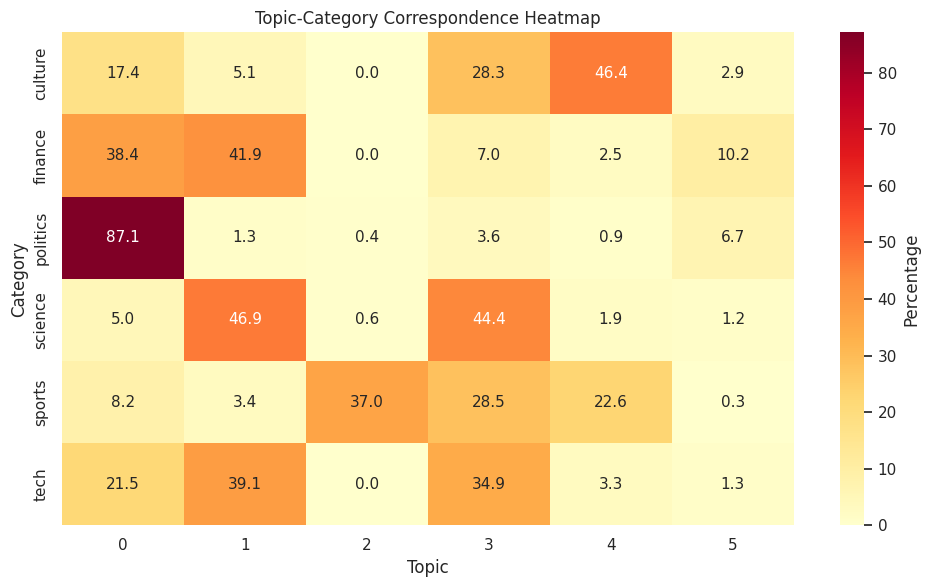

In [26]:
# Heatmap of topic-category correspondence
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    confusion,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    ax=ax,
    cbar_kws={'label': 'Percentage'}
)

ax.set_xlabel('Topic')
ax.set_ylabel('Category')
ax.set_title('Topic-Category Correspondence Heatmap')

plt.tight_layout()
plt.show()

### Topic Word Visualization

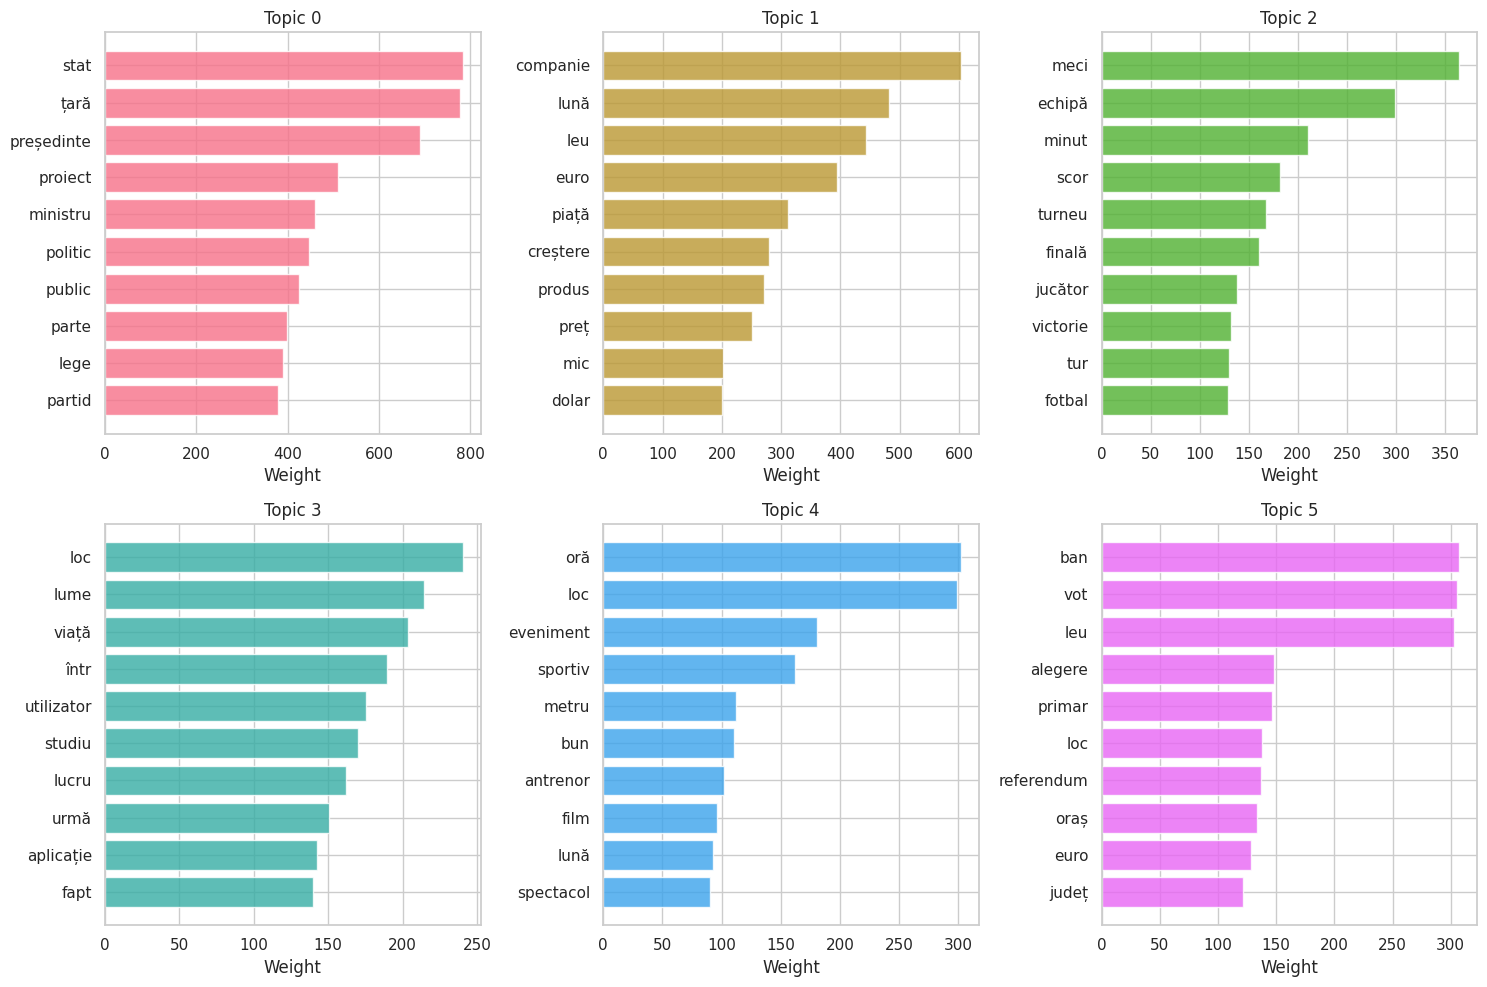

In [27]:
# Horizontal bar chart of top words per topic
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

topics = pipeline.get_topics(n_words=10)
colors = sns.color_palette('husl', n_colors=6)

for i, (topic, ax, color) in enumerate(zip(topics, axes, colors)):
    words = [w for w, _ in topic]
    weights = [w for _, w in topic]

    y_pos = np.arange(len(words))
    ax.barh(y_pos, weights, color=color, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_xlabel('Weight')
    ax.set_title(f'Topic {i}')

plt.tight_layout()
plt.show()

### Sample Documents by Topic

In [28]:
# Show sample documents for each topic
print("Sample Documents by Dominant Topic:")
print("=" * 80)

for topic_id in range(6):
    topic_docs = df_sample[df_sample['dominant_topic'] == topic_id]
    if len(topic_docs) > 0:
        # Get the document with highest confidence for this topic
        topic_probs = doc_topics[df_sample['dominant_topic'] == topic_id][:, topic_id]
        best_idx = topic_probs.argmax()
        sample_doc = topic_docs.iloc[best_idx]

        topic_words = pipeline.get_topic_words(n_words=5)[topic_id]

        print(f"\n[TOPIC {topic_id}] Keywords: {', '.join(topic_words)}")
        print(f"Category: {sample_doc['category_name']}")
        print(f"Text: {sample_doc['sample'][:250]}...")
        print("-" * 80)

Sample Documents by Dominant Topic:

[TOPIC 0] Keywords: stat, țară, președinte, proiect, ministru
Category: politics
Text: $NE$ - $NE$ în cadrul unei conferințe de presă, a prezentat rapoartele privind „$NE$ controlului parlamentar $NE$ $NE$ în anul 2017” și „$NE$ modului de ocupare / încetare a funcțiilor publice în anul 2017”, informează $NE$ . Primul raport „$NE$ cont...
--------------------------------------------------------------------------------

[TOPIC 1] Keywords: companie, lună, leu, euro, piață
Category: finance
Text: Totodată, la nouă luni, $NE$ - ul a urcat cu 7%, pe seria brută şi cu 6,9% pe seria ajustată sezonier,$NE$ cu trimestrul $NE$ din 2017, $NE$ a fost, în termeni reali, mai mare cu 2,6%, în trimestrul $NE$ 2017 . "$NE$ ajustată sezonier a $NE$ intern b...
--------------------------------------------------------------------------------

[TOPIC 2] Keywords: meci, echipă, minut, scor, turneu
Category: sports
Text: Clubul spaniol de fotbal $NE$ a anunţat că a ajuns

### Topic Coherence Analysis

In [29]:
# Analyze topic distribution per document
avg_topic_probs = doc_topics.mean(axis=0)
max_topic_probs = doc_topics.max(axis=1)

print("Topic Distribution Analysis:")
print("\nAverage topic probability across all documents:")
for i, prob in enumerate(avg_topic_probs):
    print(f"  Topic {i}: {prob:.4f}")

print(f"\nDocument confidence (max topic probability):")
print(f"  Mean: {max_topic_probs.mean():.4f}")
print(f"  Median: {np.median(max_topic_probs):.4f}")
print(f"  Min: {max_topic_probs.min():.4f}")
print(f"  Max: {max_topic_probs.max():.4f}")

Topic Distribution Analysis:

Average topic probability across all documents:
  Topic 0: 0.3582
  Topic 1: 0.2055
  Topic 2: 0.0749
  Topic 3: 0.1755
  Topic 4: 0.1026
  Topic 5: 0.0833

Document confidence (max topic probability):
  Mean: 0.6502
  Median: 0.6289
  Min: 0.1667
  Max: 0.9950


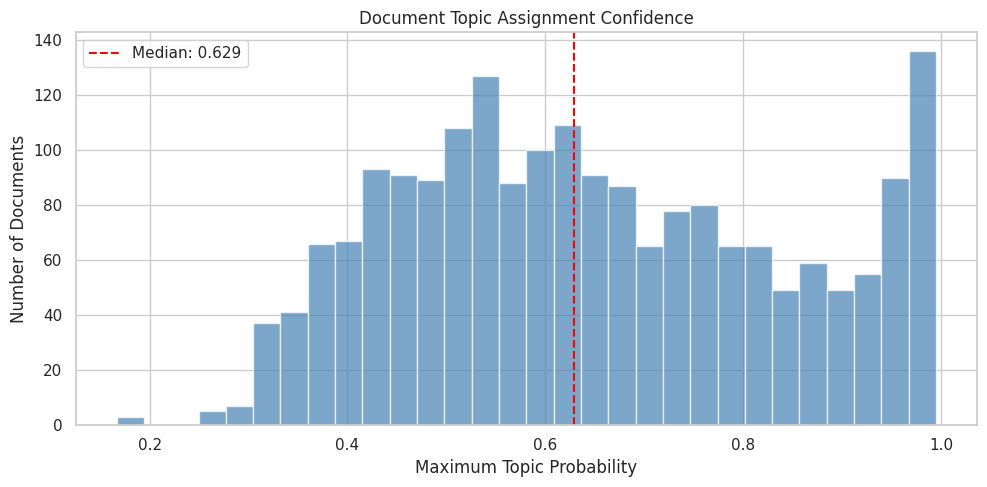

In [30]:
# Distribution of document confidence
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(max_topic_probs, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(np.median(max_topic_probs), color='red', linestyle='--',
           label=f'Median: {np.median(max_topic_probs):.3f}')
ax.set_xlabel('Maximum Topic Probability')
ax.set_ylabel('Number of Documents')
ax.set_title('Document Topic Assignment Confidence')
ax.legend()

plt.tight_layout()
plt.show()

---
## Pipeline Configuration

The pipeline is highly configurable. Here are the key parameters:

In [31]:
# Show default configuration
config = PipelineConfig()

print("Default Pipeline Configuration:")
print("=" * 60)
print("\nTF-IDF Config:")
print(f"  max_df: {config.tfidf.max_df} (prune terms in >40% of docs)")
print(f"  min_df: {config.tfidf.min_df} (prune terms in <5 docs)")
print(f"  max_features: {config.tfidf.max_features}")
print(f"  ngram_range: {config.tfidf.ngram_range} (unigrams + bigrams)")
print(f"  sublinear_tf: {config.tfidf.sublinear_tf} (1 + log(tf))")

print("\nLDA Config:")
print(f"  n_topics: {config.lda.n_topics}")
print(f"  max_iter: {config.lda.max_iter}")
print(f"  learning_method: {config.lda.learning_method}")
print(f"  random_state: {config.lda.random_state}")

print("\nPreprocessing:")
print(f"  POS tags: {config.pos_tags}")
print(f"  normalize_dialect: {config.normalize_dialect}")
print(f"  include_stopwords: {config.include_stopwords}")

Default Pipeline Configuration:

TF-IDF Config:
  max_df: 0.4 (prune terms in >40% of docs)
  min_df: 5 (prune terms in <5 docs)
  max_features: 5000
  ngram_range: (1, 2) (unigrams + bigrams)
  sublinear_tf: True (1 + log(tf))

LDA Config:
  n_topics: 6
  max_iter: 750
  learning_method: online
  random_state: 42

Preprocessing:
  POS tags: {'ADJ', 'PROPN', 'NOUN'}
  normalize_dialect: True
  include_stopwords: True


---
## Summary

This notebook demonstrated the complete `nlp-topic-modeling` pipeline:

1. **Data Loading**: Easy access to MOROCO dataset via `load_MOROCO()`
2. **Visualization**: Category distribution, text length analysis
3. **Preprocessing**: Romanian-specific normalization, POS filtering, stopwords
4. **Topic Modeling**: TF-IDF + LDA hybrid pipeline with configurable parameters
5. **Analysis**: Topic-category correspondence, document-topic distributions